# LCPB 21-22 exercise 4: XGBoost

Alessandro Zanoli, Emerson Rodrigues Vero filho, Luca Giorgetti, Raffaele Gaudio

#### TASK 1

Consider the dataset generated for exercise 03 on convolutional neural networks (CNN), namely the samples of the stochastic time series with labels 0,1,2 depending on the eventual addition of another transient signal.

a) Compare the accuracy of a CNN with that of an XGBoost model trained with the features extracted by tsfresh from same data, in the limit of small datasets. For instance, try values of N=20, 50, 100, 150, 200, 250, 300, 400, 500. In all cases show also the standard deviation of the accuracy, obtained from several independent training and test procedures on different datasets.

b) For task a) we have seen during the lesson that XGBoost finds some features more relevant than others. Find the description of those features in the documentation and try to provide an explanation of why they are relevant for that problem.

c) OPTIONAL: with the features extracted by tsfresh, train a standard (non-convolutional) feed forward neural network (FFNN) and compare the performances with those of XGBoost. Than keep only the most relevant features from XGBoost and train another FFNN with this smaller set. Is the new FFNN working better than the one trained with all features?

#### TASK 2

For the labeling of simple two dimensional data (as the one generated during the lesson), try different parameters (gamma, lambda, n_estimators, ...), aiming to find the simplest yet effective XGBoost model that keeps a good accuracy.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

plt.style.use('seaborn')
plt.rcParams['font.size'] = 14

%run plot.py

## Loading Data

In [47]:
#use the dataset generated in the last exercise (we have to use the same data as in exercise 3 because we will compare the performances of CNN and Xgboost)

str0 = 'ts_L200_Z12_A500_DX50_bias5_N10000.npy'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x=np.load(fnamex)
y=np.load(fnamey)

'''
#rearranging the labels to be unidimensional
y_2=[] 
for i in range(len(y)):
    for j in range(3):
        if y[i][j]==1:
            y_2.append(j)

y=np.array(y_2)
'''

n_class = 3 
N,L,D = len(x), len(x[0]), x.shape[2]

"""
we split the data after 

N_train= int(N*0.8)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
"""

print(x.shape)
print(y.shape)

(10000, 200, 2)
(10000, 3)


In [45]:
print(N,L,D)

10000 200 2


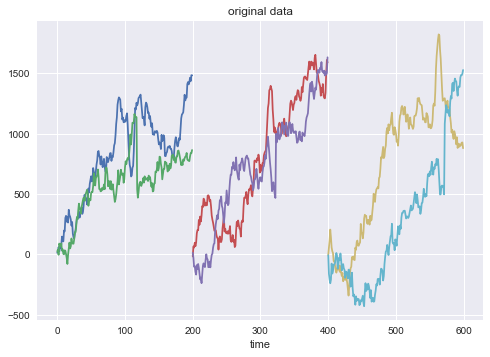

In [48]:
Show_data(x,L,"original data")

## TSFRESH: extract features

In [25]:
#per i blocchi a seguire dobbiamo aggiustare l'input (abbiamo una serie 2d)

def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t) 
    #build time columns
    time_col = np.tile(np.arange(t),N) #genera n colonne di tempi 
    #build var column
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [50]:
#first timeserie

df1=get_df(x[:,:,0])
df1

,id,time,value
0,0,0,13.0
1,0,1,18.0
2,0,2,60.0
3,0,3,24.0
4,0,4,52.0
...,...,...,...
1999995,9999,195,419.0
1999996,9999,196,454.0
1999997,9999,197,501.0
1999998,9999,198,484.0


In [51]:
df2=get_df(x[:,:,1])
df2

,id,time,value
0,0,0,24.0
1,0,1,40.0
2,0,2,-4.0
3,0,3,89.0
4,0,4,71.0
...,...,...,...
1999995,9999,195,85.0
1999996,9999,196,42.0
1999997,9999,197,73.0
1999998,9999,198,47.0


In [52]:
#extract features
x_features1 = extract_features(
                            df1, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction:   0%|                                                                                            | 0/20 [00:00<?, ?it/s]/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index w

In [53]:
x_features2 = extract_features(
                            df2, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction:   0%|                                                                                            | 0/20 [00:00<?, ?it/s]/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index w

In [54]:
#remove columns with NaN or inf
x_features1.replace([np.inf, -np.inf], np.nan)
x_features1 = x_features1.dropna(axis='columns')

x_features2.replace([np.inf, -np.inf], np.nan)
x_features2 = x_features2.dropna(axis='columns')

In [55]:
#look at clean x_features
x_features1

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,163955.0,161907519.0,40.954774,7.386935,-0.015152,864.0,...,0.055546,0.055546,0.110993,0.276868,0.804052,1.724825,2.891916,3.930799,4.632183,5.012659
1,1.0,0.0,0.0,1.0,157428.0,176980506.0,42.301508,8.070352,-0.262626,776.0,...,0.055546,0.055546,0.110993,0.110993,0.440681,1.727592,2.875956,3.966745,4.692773,5.033797
2,1.0,0.0,0.0,1.0,145815.0,166685195.0,43.839196,4.442211,-0.282828,959.0,...,0.055546,0.055546,0.055546,0.152615,0.318045,1.689628,2.884552,3.970509,4.624935,4.961393
3,1.0,0.0,0.0,1.0,166323.0,193031927.0,41.145729,8.663317,0.154040,1008.5,...,0.055546,0.055546,0.110993,0.110993,0.221586,1.708170,2.853690,3.864630,4.542631,4.929920
4,1.0,0.0,0.0,1.0,94065.0,60966921.0,49.557789,2.693467,0.141414,457.0,...,0.133708,0.133708,0.249279,0.485222,1.061854,1.721060,2.930945,4.060122,4.765871,5.130785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,1.0,79251.0,56731703.0,42.829146,4.256281,0.217172,384.0,...,0.097267,0.110993,0.110993,0.110993,0.276730,1.707419,2.893428,4.031215,4.683135,5.039051
9996,1.0,0.0,0.0,1.0,79250.0,50474726.0,52.668342,3.000000,0.166667,306.0,...,0.133708,0.252096,0.372910,0.641087,1.030776,1.702383,2.880396,3.982353,4.669703,5.038245
9997,1.0,0.0,0.0,1.0,186443.0,262221255.0,47.728643,9.256281,0.409091,960.5,...,0.055546,0.055546,0.110993,0.110993,0.615450,1.672835,2.848189,3.885281,4.486343,4.873684
9998,1.0,0.0,0.0,1.0,134581.0,120494933.0,43.195980,7.859296,0.404040,683.0,...,0.055546,0.055546,0.110993,0.276868,0.672898,1.666523,2.814337,3.868490,4.582742,4.927983


In [84]:
#look at clean x_features
x_features2


,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,115293.0,80244795.0,39.628141,4.221106,0.025253,614.0,...,0.097267,0.188954,0.276868,0.436180,1.200391,1.720251,2.939336,4.097025,4.732298,5.037300
1,1.0,0.0,0.0,1.0,143943.0,148589993.0,45.276382,8.140704,0.426768,735.5,...,0.055546,0.055546,0.110993,0.110993,0.844037,1.690199,2.834684,3.915864,4.664244,4.976722
2,1.0,0.0,0.0,1.0,53421.0,74077231.0,45.502513,7.713568,0.467172,153.5,...,0.055546,0.055546,0.055546,0.152615,0.207861,1.728750,2.983751,4.169820,4.844072,5.128444
3,1.0,0.0,0.0,1.0,202856.0,251819092.0,44.311558,7.517588,-0.116162,953.5,...,0.055546,0.055546,0.055546,0.110993,0.166340,1.686747,2.819209,3.914662,4.684482,5.051592
4,1.0,0.0,0.0,1.0,181628.0,270148134.0,53.517588,9.246231,0.022727,1124.0,...,0.055546,0.055546,0.055546,0.110993,0.395181,1.669651,2.806679,3.853692,4.534768,4.887329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,1.0,120102.0,164815346.0,43.854271,9.623116,0.343434,387.0,...,0.055546,0.055546,0.055546,0.055546,0.221586,1.670598,2.827917,3.829691,4.549053,4.895189
9996,1.0,0.0,0.0,1.0,-6989.0,23829337.0,52.195980,-1.381910,0.159091,49.0,...,0.097267,0.152615,0.244098,0.427635,0.977305,1.742166,3.028661,4.218906,4.924510,5.161916
9997,1.0,0.0,0.0,1.0,91104.0,73633106.0,55.452261,6.899497,0.121212,516.0,...,0.097267,0.152615,0.307032,0.495584,1.321976,1.655498,2.782710,3.857751,4.553248,4.912560
9998,1.0,0.0,0.0,1.0,48800.0,43300196.0,38.100503,5.015075,-0.176768,178.0,...,0.055546,0.055546,0.055546,0.110993,0.414087,1.670117,2.818461,3.887410,4.570610,4.930866


In [97]:
#accrocchio della muerte

x_features=np.array([x_features1, x_features2])

print(x_features.shape)


(2, 10000, 779)


### Split train/validation

In [88]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:,:N_train,:]
y_train = y[:N_train]
x_val = x_features[:,N_train:,:]
y_val = y[N_train:]
N_val = len(x_val)

print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)
print(x_train.shape)
print(y_train.shape)



N_train= 8000   N_val= 2   n_class= 3
(2, 8000, 779)
(8000, 3)


In [89]:
#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=1)
    [x_train[0],x_train[1]] = [x_train[0]-average[0],x_train[1]-average[1]]
    [x_val[0],x_val[1]] = [x_val[0]-average[0],x_val[1]-average[1]]

    std = np.max(x_train,axis=1)
    [x_train[0],x_train[1]] = [x_train[0]/std[0],x_train[1]/std[1]]
    [x_val[0],x_val[1]] = [x_val[0]/std[0],x_val[1]/std[1]]


In [94]:
print(type(x_train[0]))

<class 'numpy.ndarray'>


In [108]:
df_train1=pd.DataFrame(x_train[0])
df_train2=pd.DataFrame(x_train[1])
df_valid1=pd.DataFrame(x_val[0])
df_valid2=pd.DataFrame(x_val[1])


#pialleria municipale
df_train1 = df_train1.dropna(axis='columns')
df_train2 = df_train2.dropna(axis='columns')
df_valid1 = df_valid1.dropna(axis='columns')
df_valid2 = df_valid2.dropna(axis='columns')

,1,2,4,5,6,7,8,9,10,12,...,769,770,771,772,773,774,775,776,777,778
0,-6.006137e-17,2.539016e-16,0.500577,0.154371,2.750306,0.305569,-0.230935,0.500829,0.500577,0.505195,...,0.183950,0.139498,0.301907,0.397948,0.362927,21.828631,14.378714,10.887069,11.634259,22.202708
1,-6.006137e-17,2.539016e-16,0.020711,0.015153,2.665936,-0.039754,-0.160480,0.034237,0.020711,0.362612,...,0.322118,0.244277,0.192418,0.309916,0.239350,21.685054,14.351171,10.703481,11.518124,22.244580
2,-6.006137e-17,2.539016e-16,0.452981,0.167658,3.496924,0.651903,-0.027399,0.340960,0.452981,0.756349,...,0.322118,0.278748,0.547710,0.751602,0.809446,21.708485,14.216919,10.770898,11.526904,21.850006
3,-6.006137e-17,2.539016e-16,0.594108,0.271169,2.644111,0.683572,-0.266162,0.585998,0.594108,0.912348,...,0.183950,0.139498,0.109883,0.177189,0.125182,21.102612,13.772624,10.342101,11.086200,21.446746
4,-6.006137e-17,2.539016e-16,0.526047,0.203952,3.693026,0.479410,-0.066541,0.555156,0.526047,0.759267,...,0.183950,0.139498,0.301907,0.600400,0.710929,21.228648,13.548113,10.206725,11.049870,21.528438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-6.006137e-17,2.539016e-16,0.247640,0.055432,2.776366,0.285355,0.336617,0.217309,0.247640,0.466727,...,0.322118,0.278748,0.219570,0.177189,0.208258,21.875283,14.366219,10.957500,11.608748,22.241981
1996,-6.006137e-17,2.539016e-16,0.247637,0.049318,3.414184,0.201130,0.258334,0.173168,0.247637,0.405004,...,0.442798,0.633113,0.737703,1.023430,0.775728,21.810772,14.301515,10.824686,11.575453,22.238423
1997,-6.006137e-17,2.539016e-16,0.582590,0.256213,3.093972,0.620572,0.634092,0.543555,0.582590,0.872023,...,0.183950,0.139498,0.219570,0.177189,0.463168,21.432194,14.141600,10.560829,11.120933,21.512063
1998,-6.006137e-17,2.539016e-16,0.420533,0.117734,2.800145,0.526913,0.626264,0.386516,0.420533,0.507399,...,0.183950,0.139498,0.219570,0.441992,0.506400,21.351327,13.973521,10.515186,11.359890,21.751733


## XGBoost


In [39]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train.values,y_train)

XGBoostError: [16:10:14] /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/data/data.cc:981: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000138e34394 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000138e6edec unsigned long long xgboost::SparsePage::Push<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, float, int) + 1172
  [bt] (2) 3   libxgboost.dylib                    0x0000000138e9453c xgboost::data::SimpleDMatrix::SimpleDMatrix<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int) + 260
  [bt] (3) 4   libxgboost.dylib                    0x0000000138e753ec xgboost::DMatrix* xgboost::DMatrix::Create<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 60
  [bt] (4) 5   libxgboost.dylib                    0x0000000138e32fbc XGDMatrixCreateFromDense + 236
  [bt] (5) 6   libffi.8.dylib                      0x000000010379004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x000000010378d74c ffi_call_int + 1208
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x0000000103770744 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x000000010376ab78 PyCFuncPtr_call + 1196



In [ ]:
#plot tree

fig, AX = plt.subplots(3,1,figsize=(30, 10))
for i in range(3):
    ax=AX[i]
    plot_tree(model, num_trees=i, ax=ax)
    
fig.savefig("DATA/trees-time-ser.png", dpi=300, pad_inches=0.02)

In [ ]:
from sklearn.metrics import accuracy_score

#predict labels on training set
y_pred_train = model.predict(x_train)
#predict labels on validation set
y_pred_val = model.predict(x_val)

y_pred_val_soft = model.predict_proba(x_val)



#compute accuracies
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_val,y_pred_val)

#print accuracies
print('Training accuracy:',acc_train)
print('Validation accuracy:',acc_val)